<a href="https://colab.research.google.com/github/sachaathias/JPEG-Algorithm-CODO-/blob/master/jpeg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import time
import math as m
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from google.colab import files
from skimage import io, color
from scipy import fft

#L'algorithme JPEG : La Compression



##1) Introduction

La plupart des images JPEG que vous voyez sont au format JFIF (JPEG File Interchange Format), dans lequel l'algorithme de compression JPEG est appliqué. À la fin de ce notebook, vous aurez une bien meilleure compréhension de la façon dont cet algorithme compresse les données, vous aurez aussi l'implementation de cette algorithme etape par etape en python tout au long du notebook. Nous allons aussi bien vous presenter la compression que la decompression des donnee

##2) Espace colorimétrique JPEG


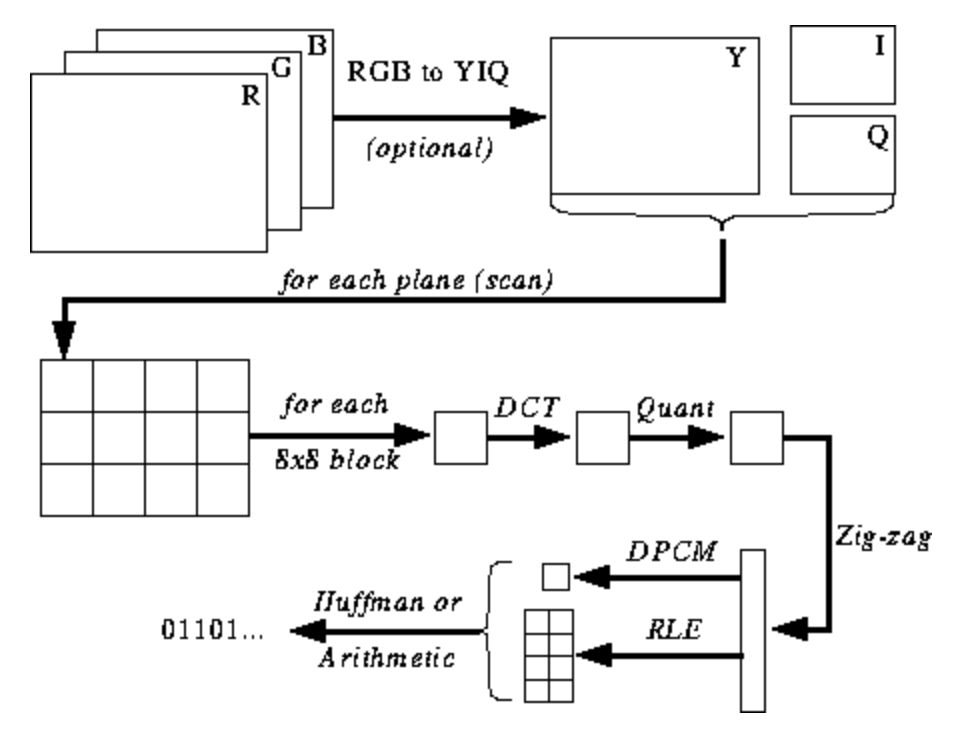
(Selon la spécification JPEG ( ISO / IEC 10918-6: 2013 (E) Section 6.1):)



*   Les images codées avec un seul composant sont traitées comme des données en niveaux de gris, où 0 est noir et 255 est blanc.
*   Les images encodées avec trois composants sont considérées comme des données RVB encodées dans l'espace YCbCr. Si l'image contient le segment de marqueur APP14 décrit dans la section 6.5.3, alors le codage couleur est considéré RVB ou YCbCr selon les informations du segment de marqueur APP14. La relation entre RVB et YCbCr est définie conformément à l'UIT-T T.871 | ISO / CEI 10918-5.
*  , , CMYK-, (0,0,0,0) . APP14, 6.5.3, CMYK YCCK APP14. CMYK YCCK 7.

La plupart des implémentations de l'algorithme JPEG utilisent la luminance et la chrominance (codage YUV) au lieu de RVB. Ceci est très utile car l'œil humain est très pauvre pour distinguer les changements de luminosité à haute fréquence dans de petites zones, vous pouvez donc réduire la fréquence et la personne ne remarquera pas la différence. Qu'est ce que ça fait? Image hautement compressée avec une dégradation de qualité presque imperceptible.
Comme en RVB, chaque pixel est encodé avec trois octets de couleurs (rouge, vert et bleu), donc en YUV, trois octets sont utilisés, mais leur signification est différente. Le composant Y définit la luminosité de la couleur (luminance ou luma). U et V définissent la couleur (chroma): U est responsable de la partie bleue et V de la partie rouge.
 Ce format a été développé à une époque où la télévision n'était pas encore si répandue et les ingénieurs voulaient utiliser le même format d'encodage d'image pour la télévision en couleur et en noir et blanc.




In [ ]:
def load_image(path):
  img = io.imread(path)
  if np.shape(img)[2] == 4:
    img = np.delete(img, 3, axis=2)
  return img

In [ ]:
def convert_to_yuv(img):
  return color.rgb2yuv(img)

def convert_to_rgb(img):
  return color.yuv2rgb(img)

In [ ]:
def seperate_channels(img):
  A, B, C = np.dsplit(img, 3)

  zeros = np.zeros(np.shape(A), dtype=int)

  A = np.concatenate((A, zeros, zeros), axis=2)
  B = np.concatenate((zeros, B, zeros), axis=2)
  C = np.concatenate((zeros, zeros, C), axis=2)
  #io.imshow(C)
  return A, B, C

In [ ]:
def greyscale(img):
  A, B, C = np.dsplit(img, 3)
  
  if not np.all(A == 0):
    current = A
  elif not np.all(B == 0):
    current = B
  else:
    current = C

  return np.concatenate((current, current, current), axis=2)

In [ ]:
def complete_image(img):
  height, width, rgb = np.shape(img)
  need_line = (8 - height % 8)

  new_lines = img[height - 1:height - need_line - 1:-1, :]
  resize_img = np.vstack((img, new_lines))

  height, width, rgb = np.shape(resize_img)
  need_column = (8 - width % 8)
  new_columns = resize_img[:, width - 1:width - need_column - 1:-1]

  resize_img = np.hstack((resize_img, new_columns))

  return resize_img

##Transformée discrète en cosinus et quantification

JPEG convertit l'image en blocs 8x8 de pixels (appelés MCU, unité de codage minimum), modifie la plage de valeurs de pixel de sorte que le centre soit 0, puis applique une transformation en cosinus discrète à chaque bloc et compresse le résultat à l'aide de la quantification. Voyons ce que tout cela signifie.
La transformée en cosinus discrète (DCT) est une méthode de transformation de données discrètes en combinaisons d'ondes cosinus. Convertir une image en un ensemble de cosinus ressemble à un exercice futile à première vue, mais vous en comprendrez la raison lorsque vous en saurez plus sur les étapes suivantes. DCT prend un bloc de 8x8 pixels et nous indique comment reproduire ce bloc en utilisant une matrice de fonctions cosinus 8x8. Plus de détails ici .

La matrice ressemble à ceci:


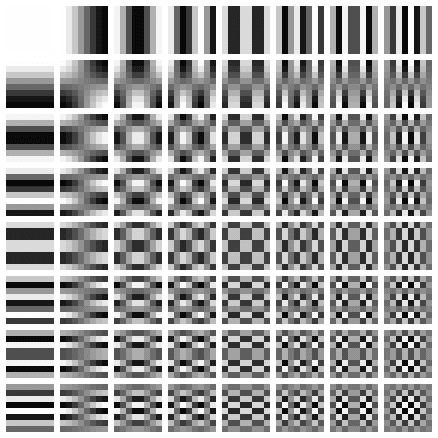

Nous appliquons DCT séparément à chaque composant de pixel. En conséquence, nous obtenons une matrice 8x8 de coefficients, qui montre la contribution de chacune (des 64) fonctions cosinus dans la matrice d'entrée 8x8. Dans la matrice des coefficients DCT, les plus grandes valeurs se trouvent généralement dans le coin supérieur gauche et les plus petites dans le coin inférieur droit. Le coin supérieur gauche est la fonction cosinus de fréquence la plus basse et le coin inférieur droit est le plus élevé.Cela signifie que dans la plupart des images, il y a une énorme quantité d'informations à basse fréquence et une petite proportion d'informations à haute fréquence. Si les composantes en bas à droite de chaque matrice DCT reçoivent la valeur 0, l'image résultante nous semblera la même, car une personne ne distingue pas mal les changements à haute fréquence. C'est ce que nous ferons à l'étape suivante.
 



In [ ]:
def divide_block(img):
  height, width, _ = np.shape(img)

  blocks = []

  for i in range(0, height, 8):
    for j in range(0, width, 8):
      blocks.append(img[i:i + 8, j:j + 8, 0])

  return blocks

In [ ]:
# Paste the DCT matrix see in the course
dct_matrix = np.array([[1/m.sqrt(2), 1/m.sqrt(2), 1/m.sqrt(2), 1/m.sqrt(2), 1/m.sqrt(2), 1/m.sqrt(2), 1/m.sqrt(2), 1/m.sqrt(2)],
              [m.cos(m.pi/16), m.cos(3*m.pi/16), m.cos(5*m.pi/16), m.cos(7*m.pi/16), m.cos(9*m.pi/16), m.cos(11*m.pi/16), m.cos(13*m.pi/16), m.cos(15*m.pi/16)],
              [m.cos(2*m.pi/16), m.cos(6*m.pi/16), m.cos(10*m.pi/16), m.cos(14*m.pi/16), m.cos(18*m.pi/16), m.cos(22*m.pi/16), m.cos(26*m.pi/16), m.cos(30*m.pi/16)],
              [m.cos(3*m.pi/16), m.cos(9*m.pi/16), m.cos(15*m.pi/16), m.cos(21*m.pi/16), m.cos(27*m.pi/16), m.cos(33*m.pi/16), m.cos(39*m.pi/16), m.cos(45*m.pi/16)],
              [m.cos(4*m.pi/16), m.cos(12*m.pi/16), m.cos(20*m.pi/16), m.cos(28*m.pi/16), m.cos(36*m.pi/16), m.cos(44*m.pi/16), m.cos(52*m.pi/16), m.cos(60*m.pi/16)],
              [m.cos(5*m.pi/16), m.cos(15*m.pi/16), m.cos(25*m.pi/16), m.cos(35*m.pi/16), m.cos(45*m.pi/16), m.cos(55*m.pi/16), m.cos(65*m.pi/16), m.cos(75*m.pi/16)],
              [m.cos(6*m.pi/16), m.cos(18*m.pi/16), m.cos(30*m.pi/16), m.cos(42*m.pi/16), m.cos(54*m.pi/16), m.cos(66*m.pi/16), m.cos(78*m.pi/16), m.cos(90*m.pi/16)],
              [m.cos(7*m.pi/16), m.cos(21*m.pi/16), m.cos(35*m.pi/16), m.cos(49*m.pi/16), m.cos(63*m.pi/16), m.cos(77*m.pi/16), m.cos(91*m.pi/16), m.cos(105*m.pi/16)]]) * 1/2

# Quantification matrix Q
quant_matrix = np.array([[16, 11, 10, 16, 24, 40, 51, 61],
                         [12, 12, 14, 19, 26, 58, 60, 55],
                         [14, 13, 16, 24, 40, 57, 69, 56],
                         [14, 17, 22, 29, 51, 87, 80, 62],
                         [18, 22, 37, 56, 68, 109, 103, 77],
                         [24, 35, 55, 64, 81, 104, 113, 92],
                         [49, 64, 78, 87, 103, 121, 120, 101],
                         [72, 92, 95, 98, 112, 100, 103, 99]])

In [ ]:
# All JPEG tables
DCTable = [
    ("010", 3), ("011", 4), ("100", 5), ("00", 5),
    ("101", 7), ("110", 8), ("1110", 10),
    ("11110", 12), ("111110", 14), ("1111110", 16),
    ("11111110", 18), ("111111110", 20)
]

ACTable = [
    [  # 0/0 - 0/A
        ("1010", 4),
        ("00", 3),
        ("01", 4),
        ("100", 6),
        ("1011", 8),
        ("11010", 10),
        ("111000", 12),
        ("1111000", 14),
        ("1111110110", 18),
        ("1111111110000010", 25),
        ("1111111110000011", 26),
    ],
    [  # 1/1 - 1/A
        ("0", -1),
        ("1100", 5),
        ("111001", 8),
        ("1111001", 10),
        ("111110110", 13),
        ("11111110110", 16),
        ("1111111110000100", 22),
        ("1111111110000101", 23),
        ("1111111110000110", 24),
        ("1111111110000111", 25),
        ("1111111110001000", 26),
    ],
    [  # 2/1 - 2/A
        ("0", -1),
        ("11011", 6),
        ("11111000", 10),
        ("1111110111", 13),
        ("1111111110001001", 20),
        ("1111111110001010", 21),
        ("1111111110001011", 22),
        ("1111111110001100", 23),
        ("1111111110001101", 24),
        ("1111111110001110", 25),
        ("1111111110001111", 26),
    ],
    [  # 3/1 - 3/A
        ("0", -1),
        ("111010", 7),
        ("111110111", 11),
        ("11111110111", 14),
        ("1111111110010000", 20),
        ("1111111110010001", 21),
        ("1111111110010010", 22),
        ("1111111110010011", 23),
        ("1111111110010100", 24),
        ("1111111110010101", 25),
        ("1111111110010110", 26),
    ],
    [  # 4/1 - 4/A
        ("0", -1),
        ("111011", 7),
        ("1111111000", 12),
        ("1111111110010111", 19),
        ("1111111110011000", 20),
        ("1111111110011001", 21),
        ("1111111110011010", 22),
        ("1111111110011011", 23),
        ("1111111110011100", 24),
        ("1111111110011101", 25),
        ("1111111110011110", 26),
    ],
    [  # 5/1 - 5/A
        ("0", -1),
        ("1111010", 8),
        ("1111111001", 12),
        ("1111111110011111", 19),
        ("1111111110100000", 20),
        ("1111111110100001", 21),
        ("1111111110100010", 22),
        ("1111111110100011", 23),
        ("1111111110100100", 24),
        ("1111111110100101", 25),
        ("1111111110100110", 26),
    ],
    [  # 6/1 - 6/A
        ("0", -1),
        ("1111011", 8),
        ("11111111000", 13),
        ("1111111110100111", 19),
        ("1111111110101000", 20),
        ("1111111110101001", 21),
        ("1111111110101010", 22),
        ("1111111110101011", 23),
        ("1111111110101100", 24),
        ("1111111110101101", 25),
        ("1111111110101110", 26),
    ],
    [  # 7/1 - 7/A
        ("0", -1),
        ("11111001", 9),
        ("11111111001", 13),
        ("1111111110101111", 19),
        ("1111111110110000", 20),
        ("1111111110110001", 21),
        ("1111111110110010", 22),
        ("1111111110110011", 23),
        ("1111111110110100", 24),
        ("1111111110110101", 25),
        ("1111111110110110", 26),
    ],
    [  # 8/1 - 8/A
        ("0", -1),
        ("11111010", 9),
        ("111111111000000", 17),
        ("1111111110110111", 19),
        ("1111111110111000", 20),
        ("1111111110111001", 21),
        ("1111111110111010", 22),
        ("1111111110111011", 23),
        ("1111111110111100", 24),
        ("1111111110111101", 25),
        ("1111111110111110", 26),
    ],
    [  # 9/1 - 9/A
        ("0", -1),
        ("111111000", 10),
        ("1111111110111111", 18),
        ("1111111111000000", 19),
        ("1111111111000001", 20),
        ("1111111111000010", 21),
        ("1111111111000011", 22),
        ("1111111111000100", 23),
        ("1111111111000101", 24),
        ("1111111111000110", 25),
        ("1111111111000111", 26),
    ],
    [  # A/1 - A/A
        ("0", -1),
        ("111111001", 10),
        ("1111111111001000", 18),
        ("1111111111001001", 19),
        ("1111111111001010", 20),
        ("1111111111001011", 21),
        ("1111111111001100", 22),
        ("1111111111001101", 23),
        ("1111111111001110", 24),
        ("1111111111001111", 25),
        ("1111111111010000", 26),
    ],
    [  # B/1 - B/A
        ("0", -1),
        ("111111010", 10),
        ("1111111111010001", 18),
        ("1111111111010010", 19),
        ("1111111111010011", 20),
        ("1111111111010100", 21),
        ("1111111111010101", 22),
        ("1111111111010110", 23),
        ("1111111111010111", 24),
        ("1111111111011000", 25),
        ("1111111111011001", 26),
    ],
    [  # C/1 - C/A
        ("0", -1),
        ("1111111010", 11),
        ("1111111111011010", 18),
        ("1111111111011011", 19),
        ("1111111111011100", 20),
        ("1111111111011101", 21),
        ("1111111111011110", 22),
        ("1111111111011111", 23),
        ("1111111111100000", 24),
        ("1111111111100001", 25),
        ("1111111111100010", 26),
    ],
    [  # D/1 - D/A
        ("0", -1),
        ("11111111010", 12),
        ("1111111111100011", 18),
        ("1111111111100100", 19),
        ("1111111111100101", 20),
        ("1111111111100110", 21),
        ("1111111111100111", 22),
        ("1111111111101000", 23),
        ("1111111111101001", 24),
        ("1111111111101010", 25),
        ("1111111111101011", 26),
    ],
    [  # E/1 - E/A
        ("0", -1),
        ("111111110110", 13),
        ("1111111111101100", 18),
        ("1111111111101101", 19),
        ("1111111111101110", 20),
        ("1111111111101111", 21),
        ("1111111111110000", 22),
        ("1111111111110001", 23),
        ("1111111111110010", 24),
        ("1111111111110011", 25),
        ("1111111111110100", 26),
    ],
    [  # F/0 - F/A
        ("111111110111", 12),  # F/0 => 16 zeros d'affilés
        ("1111111111110101", 17),
        ("1111111111110110", 18),
        ("1111111111110111", 19),
        ("1111111111111000", 20),
        ("1111111111111001", 21),
        ("1111111111111010", 22),
        ("1111111111111011", 23),
        ("1111111111111100", 24),
        ("1111111111111101", 25),
        ("1111111111111110", 26),
    ]
]


In [ ]:
def DCT(blocks):
  dct_blocks = []

  for block in blocks:
    matrix = dct_matrix @ (block - 128) @ np.transpose(dct_matrix)
    dct_blocks.append(matrix.round().astype('int64'))

  return dct_blocks

##3) Quantification

Nous savons tous que JPEG est un algorithme de compression avec perte. Mais jusqu'à présent, nous n'avons rien perdu. Nous n'avons que des blocs de composantes YUV 8x8 convertis en blocs de fonctions cosinus 8x8 sans perte d'information. L'étape de perte de données est la quantification.
La quantification est le processus lorsque nous prenons deux valeurs d'une certaine plage et les transformons en une valeur discrète. Dans notre cas, ce n'est qu'un nom sournois pour réduire à 0 les coefficients de fréquence les plus élevés dans la matrice DCT résultante. Lors de l'enregistrement d'une image au format JPEG, la plupart des éditeurs graphiques vous demandent quel niveau de compression vous souhaitez définir. C'est là que se produit la perte d'informations à haute fréquence. Vous ne pourrez plus recréer l'image d'origine à partir de l'image JPEG résultante.
 
 Différentes matrices de quantification sont utilisées en fonction du taux de compression. Nous divisons la matrice DCT des coefficients élément par élément par la matrice de quantification, arrondissons les résultats aux entiers et obtenons la matrice quantifiée.


 * Regardons un exemple. Disons qu'il existe une telle matrice DCT:

 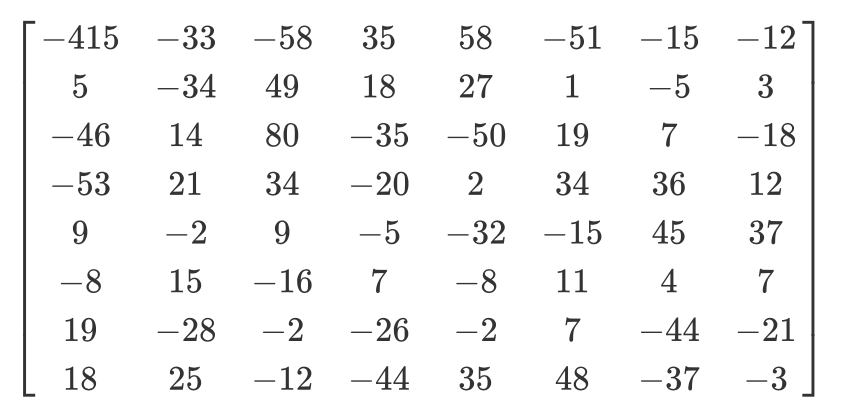

* Et voici la matrice de quantification habituelle:
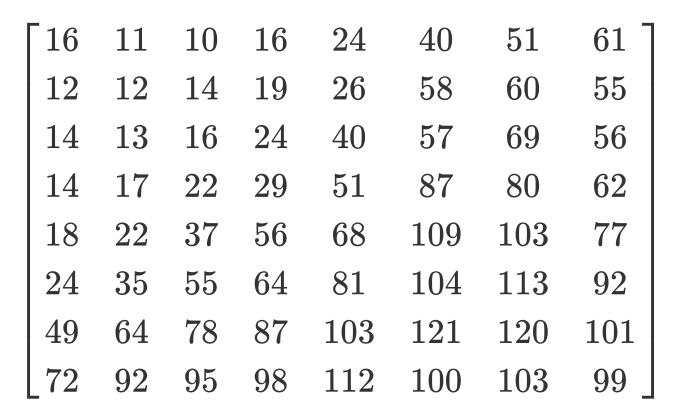

* La matrice quantifiée ressemblera à ceci:



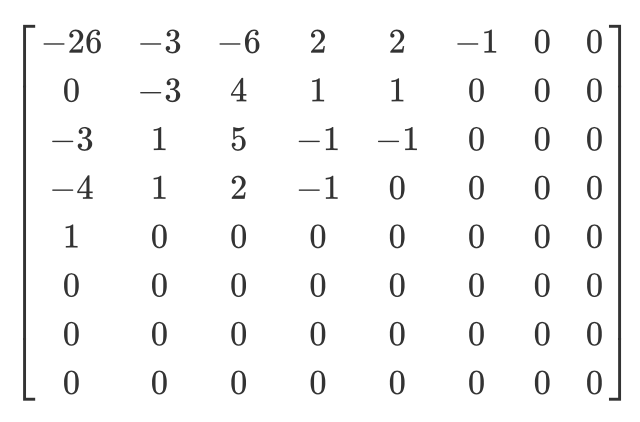

Bien que les humains ne puissent pas voir les informations à haute fréquence, si vous supprimez trop de données des blocs de 8x8 pixels, l'image aura l'air trop grossière. Dans une telle matrice quantifiée, la toute première valeur est appelée la valeur DC, et le reste est appelé la valeur AC. Si nous prenions les valeurs DC de toutes les matrices quantifiées et produisions une nouvelle image, nous obtiendrions un aperçu avec une résolution 8 fois plus petite que l'image d'origine.

Il faut garder a l'esprit puisque nous avons utilisé la quantification, nous devons nous assurer que les couleurs se situent dans la plage de [0,255]. S'ils s'envolent, il faut les amener manuellement à cette plage.


In [ ]:
def quantification(blocks):
  quant_blocks = []

  for block in blocks:
    quant_blocks.append(np.divide(block, quant_matrix).round().astype('int64'))

  return quant_blocks

##4) ZigZag

Après la quantification, l'algorithme JPEG utilise un balayage en zigzag pour convertir la matrice en une forme unidimensionnelle:
 
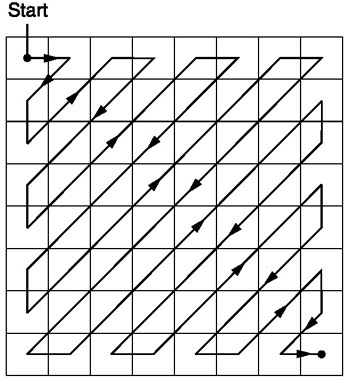

Ce codage est préféré car après la quantification, la plupart des informations basse fréquence (les plus importantes) seront localisées au début de la matrice, et le balayage en zigzag stocke ces données au début de la matrice unidimensionnelle. Ceci est utile pour l'étape suivante, la compression.


In [ ]:
def zigzag_matrix(blocks):
  zigzag_list = []

  for block in blocks:
    reverse = True
    zigzag = []

    for i in range(-7, 7):
      diagonal = np.diagonal(np.rot90(block), axis1=0, axis2=1, offset=i)
      if reverse:
        diagonal = np.flip(diagonal)

      reverse = not reverse
      zigzag = np.concatenate((zigzag, diagonal))
    

    zigzag_list.append(np.trim_zeros(zigzag.astype('int64'), trim='b'))

  return zigzag_list

##5) Codage Huffman

Le codage de Huffman est un algorithme de compression de données sans perte. Le codage de Huffman utilise un code à longueur variable pour représenter un symbole de la source (par exemple un caractère dans un fichier). Le code est déterminé à partir d'une estimation des probabilités d'apparition des symboles de source, un code court étant associé aux symboles de source les plus fréquents.

Un JPEG contient jusqu'à quatre tables de Huffman, qui sont stockées dans la section «Définir la table de Huffman» (commence par 0xffc4). Les coefficients DCT sont stockés dans deux tables de Huffman différentes: dans l'une les valeurs DC des tables en zigzag, dans l'autre - les valeurs AC des tables en zigzag. Cela signifie que lors du codage, nous devons combiner les valeurs DC et AC des deux matrices. Les informations DCT pour les canaux de luminance et de chromaticité sont stockées séparément, nous avons donc deux ensembles d'informations CC et deux ensembles d'informations CA, soit un total de 4 tables de Huffman. 

Si l'image est en niveaux de gris, nous n'avons que deux tables de Huffman (une pour DC et une pour AC), car nous n'avons pas besoin de couleur. Comme vous l'avez peut-être compris, deux images différentes peuvent avoir des tables de Huffman très différentes, il est donc important de les stocker dans chaque JPEG.
 


In [ ]:
def get_jpeg_coefficient_coding_categories():
  result = []
  for i in range(16):
    line = []
    if i == 0:
      line.append(0)
    else:
      for j in range(-pow(2, i) + 1, -pow(2, i-1) + 1):
        line.append(j)
      for j in range(pow(2, i-1), pow(2, i)):
        line.append(j)
    result.append(line)
  return result

In [ ]:
def apply_huffman(n, jpeg_coefficient, prev_zero=0, isDC=False):
  dc, ac, index = 0, 0, 0
  for i in range(len(jpeg_coefficient)):
    if abs(n) <= abs(jpeg_coefficient[i][0]):
      dc, ac, index = i, i, jpeg_coefficient[i].index(n)
      break

  index = bin(index).replace("0b", "")
  for _ in range(dc - len(index)):
    index = '0' + index

  dc_ac = ''
  if isDC:
    dc_ac = DCTable[dc][0]
  else:
    dc_ac = ACTable[prev_zero][ac][0]

  if (dc_ac == "111111110111" and not isDC) or (dc_ac == "010" and isDC):
    return dc_ac

  return dc_ac + index

In [ ]:
def huffman(blocks):
  previous_dc = 0
  result = ""
  jpeg_coefficients = get_jpeg_coefficient_coding_categories()

  for block in blocks:
    previous_zeros = 0
    # Do DC number    
    DC = block[0] - previous_dc
    result += apply_huffman(DC, jpeg_coefficients, isDC=True)
    previous_dc = DC

    for i in range(1, len(block)):
      if block[i] == 0:
        if previous_zeros == 15:
          result += apply_huffman(block[i], jpeg_coefficients, previous_zeros)
          previous_zeros = 1
        else:
          previous_zeros += 1
      else:
        result += apply_huffman(block[i], jpeg_coefficients, previous_zeros)
        previous_zeros = 0
        
    result += "1010"
  
  return result

In [ ]:
def compress_jpeg_black_white(img):
  grey = greyscale(img)

  grey_resize = complete_image(grey)

  divide = divide_block(grey_resize)

  dct = DCT(divide)

  quant = quantification(dct)

  zig_mat = zigzag_matrix(quant)

  return huffman(zig_mat)

In [ ]:

def compress_jpeg(file, is_yuv = False):
  img = load_image(file)
  size = np.shape(img)
  img_size = size[0], size[1]
  if is_yuv:
    img = convert_to_yuv(img)
  chan1, chan2, chan3 = seperate_channels(img)
  chan1_huffman = compress_jpeg_black_white(chan1)
  chan2_huffman = compress_jpeg_black_white(chan2)
  chan3_huffman = compress_jpeg_black_white(chan3)

  return chan1_huffman, chan2_huffman, chan3_huffman, img_size


#L'algorithme JPEG: La Decompression

In [ ]:
def find_DCTable(block):
  for i in range(len(DCTable)):
    if (DCTable[i][0] == block):
      return (i, DCTable[i][1])
  return None

def find_ACTable(block):
  for i in range(len(ACTable)):
    for j in range(len(ACTable[i])):
      if ACTable[i][j][1] != -1:
        if (ACTable[i][j][0] == block):
          return (i, j, ACTable[i][j][1])
  return None

def find_JPEGTable(categorie, index, JPEGTable):
  return JPEGTable[categorie][index]

In [ ]:
def inverse_huffman(channel):
  JPEGTable = get_jpeg_coefficient_coding_categories()
  blocks = []
  paquet = ""
  is_DC = True
  block = []
  prev_DC = 0
  start = 0
  i = 0
  while i  < len(channel):
     paquet += channel[i]
     if paquet == "1010":
       blocks.append(np.array(block))
       block = []
       is_DC = True
       paquet = ""
       start = i + 1
     elif is_DC:
       DC = find_DCTable(paquet)
       if not DC:
         i +=1
         continue
       is_DC = False
       i+=1
       paquet = channel[i: start + DC[1]]
       curr_DC = (0 if DC[0] == 0 else find_JPEGTable(DC[0], int(paquet, 2), JPEGTable)) + prev_DC
       prev_DC = 0 if DC[0] == 0 else find_JPEGTable(DC[0], int(paquet, 2), JPEGTable)
       block.append(curr_DC)
       paquet = ""
       start += DC[1]
       i = start - 1
     else:
       AC = find_ACTable(paquet)
       if not AC:
         i+= 1
         continue
       i += 1
       paquet = channel[i: start + AC[2]]
       for _ in range(AC[0]):
         block.append(0)
       if not (AC[0] == 15 and AC[1] == 0):
         block.append(find_JPEGTable(AC[1], int(paquet, 2), JPEGTable))
       paquet = ""
       start += AC[2]
       i = start - 1
     i+=1

  return blocks

In [ ]:
indexes = [(0, 0), (0, 1), (1, 0), (2, 0), (1, 1), (0, 2), (0, 3), (1, 2), (2, 1), (3, 0), (4, 0), (3, 1), (2, 2), (1, 3), (0, 4), (0, 5), (1, 4), (2, 3), (3, 2), (4, 1), (5, 0),
             (6, 0), (5, 1), (4, 2), (3, 3), (2, 4), (1, 5), (0, 6), (0, 7), (1, 6), (2, 5), (3, 4), (4, 3), (5, 2), (6, 1), (7, 0), (7, 1), (6, 2), (5, 3), (4, 4), (3, 5), (2, 6),
             (1, 7), (2, 7), (3, 6), (4, 5), (5, 4), (6, 3), (7, 2), (7, 3), (6, 4), (5, 5), (4, 6), (3, 7), (4, 7), (5, 6), (6, 5), (7, 4), (7, 5), (6, 6), (5, 7), (6, 7), (7, 0),
             (7, 7)]

def inverse_zigzag(matrix, list):
  for e, (i, j) in zip(list, indexes):
    matrix[i, j] = e
  return matrix

In [ ]:
def inverse_zigzag_matrix(input):
  blocks = []
  for inp in input:
    block = inverse_zigzag(np.zeros((8, 8), dtype='int32'), inp)
    blocks.append(block)
  return blocks

In [ ]:
def inverse_quantification(blocks):
  quant_blocks = []

  for block in blocks:
    product = block * quant_matrix
    quant_blocks.append(product)

  return quant_blocks

In [ ]:
def inverse_DCT(dct_blocks):
  blocks = []
  inv_dct_matrix = np.linalg.inv(dct_matrix)
  for block in dct_blocks:
    matrix = (inv_dct_matrix @ block @ np.transpose(inv_dct_matrix)) + 128
    blocks.append(matrix.round().astype('int64'))

  return blocks

In [ ]:
def block_combination(blocks, img_size):
  img_size_rounded = img_size[0] + (8 - (img_size[0]% 8)), img_size[1] + (8 - (img_size[1]% 8))
  matrix_image = np.zeros(img_size_rounded, dtype="int32")
  start_x = 0
  start_y = 0

  for block in blocks:
    y = 0
    for i in range(start_y, start_y + 8):
      x = 0
      for j in range(start_x, start_x + 8):
        matrix_image[i,j] = block[y, x]
        x+=1
      y+=1
    start_x += 8
    if start_x >= img_size_rounded[1]:
      start_y += 8
      start_x = 0

  return matrix_image

In [ ]:
def converte_dim(chanel):
  shape = np.shape(chanel)
  matrix = np.zeros((shape[0], shape[1], 1))
  for i in range(shape[0]):
    for j in range(shape[1]):
      matrix[i,j,0] = chanel[i, j]
  return matrix

def decompress_jpeg_chan(channel, img_size):
  invHuff = inverse_huffman(channel)
  invZigZag = inverse_zigzag_matrix(invHuff)
  invQuant = inverse_quantification(invZigZag)
  invDct = inverse_DCT(invQuant)
  return block_combination(invDct, img_size)

def decompress_jpeg(chan1, chan2, chan3, img_size, is_yuv = False):
  channels = decompress_jpeg_chan(chan1, img_size) , decompress_jpeg_chan(chan2, img_size) , decompress_jpeg_chan(chan3, img_size)
  channels = converte_dim(channels[0]), converte_dim(channels[1]), converte_dim(channels[2])
  matrix_image = np.concatenate(channels, axis=2).astype("int32")

  if is_yuv:
    return convert_to_rgb(matrix_image)

  return matrix_image[:img_size[0], :img_size[1], :]


#Pipeline Compression / Decompression

Veuillez executer la cellule ci-dessous pour upload l'image png que vous voulez compressez

Saving randompic_color.png to randompic_color.png


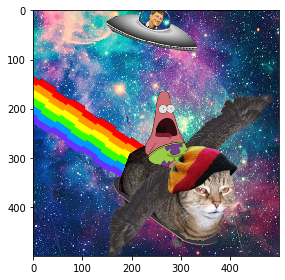

In [ ]:
uploaded = files.upload()
key = list(uploaded.keys())
img = load_image(key[0])
io.imshow(img)


Pour compresser l'image précédemment téléchargé veuillez exécuter la cellule ci-dessous (Pour compressez en utilisant l'espace de couleur YUV passez l'agument de compress_jpeg de False a True)

In [ ]:

compress_start = time.time()
chan1, chan2, chan3, size_file= compress_jpeg(key[0], False)
compress_end = time.time()

print("Taille de l'image:", size_file[0],"x", size_file[1])
print("Temps de compression:", compress_end - compress_start)
print()
print("-- Code Huffman resultant --")
print("Channel1:", chan1)
print("Channel2:", chan2)
print("Channel3:", chan3)

Taille de l'image: 500 x 500
Temps de compression: 5.5431835651397705

-- Code Huffman resultant --
Channel1: 11100111111101001011110001011011110111001010001111110010101100011100100111011000011110100111101000011010111010010010110000101110101001000110010100000000000111000001000111010011000000111010111011110100010011010011001001110011111101110100100000101011111010111110111001101011101110011111100010110011010001010001110100101011101101110010100111001100011101111010000111001011000000000010100111001010000101110111110011100111001101011101100010101100000110010110111001011110010111011110100011001001000011101100000010010011101111010111011000010010010001111001001111010111000110110111011010100010011100101010101000101110001100011000110001010111010110011100111010111000111101101010101000010011010111010011010000110011000100111000111011011101101111010000110101011001110101001011010101010101011010111001011101010101100011001001010111011000011001001110111110111101000000101100100010101100100100011110001110

Et pour finir afin de décompresser l'image  il faut juste excuter la dernière cellule de la pipeline (Si vous avez compressez en utilisant l'espace YUV il faudra passez l'argument de decompress_jpeg de False a True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Temps de decompression: 19.19514560699463


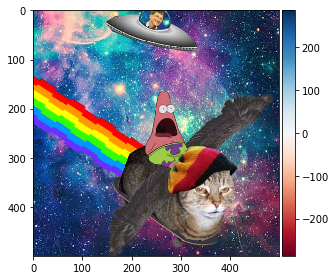

In [ ]:
decompress_start = time.time()
decompressed_img = decompress_jpeg(chan1, chan2, chan3, size_file, False)
decompress_end = time.time()
print("Temps de decompression:", decompress_end - decompress_start)

io.imshow(decompressed_img)


#Pipeline pour un bloc unique

In [ ]:
# Test matrix in the slide
test_matrix = np.array([[52, 55, 61, 66, 70, 61, 64, 73],
                       [63, 59, 55, 90, 109, 85, 69, 72],
                       [62, 59, 68, 113, 144, 104, 66, 73],
                       [63, 58, 71, 122, 154, 106, 70, 69],
                       [67, 61, 68, 104, 126, 88, 68, 70],
                       [79, 65, 60, 70, 77, 68, 58, 75],
                       [85, 71, 64, 59, 55, 61, 65, 83],
                       [87, 79, 69, 68, 65, 76, 78, 94]])

def test_jpeg(test_block):
  print("-- Compression --")
  print("Bloc utilisé:")
  print(test_block)
  print()

  test = [test_block]
  test_dct = DCT(test)
  print("DCT:")
  print(test_dct[0])
  print()

  test_quant = quantification(test_dct)
  print("Quantification:")
  print(test_quant[0])
  print()

  zig_test = zigzag_matrix(test_quant)
  print("Ordre zigzag:")
  print(zig_test[0])
  print()

  huffman_test = huffman(zig_test)
  print("Code huffman:")
  print(huffman_test)
  print()
  print()

  print("-- Decompression --")
  decode_huffman = inverse_huffman(huffman_test)
  print("Code huffman décodé:")
  print(decode_huffman[0])
  print()

  inverse_zig = inverse_zigzag_matrix(decode_huffman)
  print("Zigzag inversé:")
  print(inverse_zig[0])
  print()

  inverse_quant = inverse_quantification(inverse_zig)
  print("Quantification inversé:")
  print(inverse_quant[0])
  print()

  inverse_dct = inverse_DCT(inverse_quant)
  print("DCT inversé:")
  print(inverse_dct[0])
  print()

test_jpeg(test_matrix)

-- Compression --
Bloc utilisé:
[[ 52  55  61  66  70  61  64  73]
 [ 63  59  55  90 109  85  69  72]
 [ 62  59  68 113 144 104  66  73]
 [ 63  58  71 122 154 106  70  69]
 [ 67  61  68 104 126  88  68  70]
 [ 79  65  60  70  77  68  58  75]
 [ 85  71  64  59  55  61  65  83]
 [ 87  79  69  68  65  76  78  94]]

DCT:
[[-415  -30  -61   27   56  -20   -2    0]
 [   4  -22  -61   10   13   -7   -9    5]
 [ -47    7   77  -25  -29   10    5   -6]
 [ -49   12   34  -15  -10    6    2    2]
 [  12   -7  -13   -4   -2    2   -3    3]
 [  -8    3    2   -6   -2    1    4    2]
 [  -1    0    0   -2   -1   -3    4   -1]
 [   0    0   -1   -4   -1    0    1    2]]

Quantification:
[[-26  -3  -6   2   2   0   0   0]
 [  0  -2  -4   1   0   0   0   0]
 [ -3   1   5  -1  -1   0   0   0]
 [ -4   1   2  -1   0   0   0   0]
 [  1   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0]]

Ordre zigzag:
[-26  -3   0  -3  -2  -